# Applied Data Science Capstone - The Battle of Neighborhoods Week5

## 1. Introduction of this project - A data journey to London

The other day I received an email from a friend of mine in Japan and he told me he has received an attractive offer from a company in London. He is now planning to relocate with his wife and a 4-year-old boy.
However, he has no experience of living abroad and do not have a clue where to start with finding a right information of the neighborhood there. 
So I have decided to help him with my newly acquired skill of data analysis from the data science course at Coursera.

### Goal of the project: To find suitable accommodation areas inside/around London for a family with a small kid who loves Asian cuisine.

## 2. Data

I first decided to check the crime rate as it is usually the most importatant condition for a family with small children. I also know that they love Asian cuisine and they cannot live without it. So this needs to be taken into account as well.

### Target: Find an area(s) with 1) Low number in criminal cases and 2) Good access to Asian cuisine  (Extra - (if possible) good access to Metro station(s) )

### Data source

#### 1) Criminal Record in London - https://data.london.gov.uk/dataset/recorded_crime_summary (MPS Borough Level Crime in csv format)
#### 2) Geographical coordinate fo Boroughs and Wards in London - https://data.london.gov.uk/dataset/excel-mapping-template-for-london-boroughs-and-wards
#### 3) Neighborhood Venues - with Foursquare API.
#### (4) Location of Metro Stations in London - https://www.doogal.co.uk/london_stations.php (Name of the station, Geographical coordinate(longitute, latititude))

1) Criminal Record in London includes the category of crime, Borough Name and the number of crimes for each month from June.2018 till May, 2020. 

2) Geographical coordinate of Boroughs and Wards in London recquires cleaning as they are not in one file.

## 3. Data Analysis

Importing libraries

In [3]:
import numpy as np 
import pandas as pd

import json

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure #importing Figure artist

from sklearn.cluster import KMeans

import folium # map rendering library


### Let's start looking at the data set from Crime Data in London

In [4]:
df_crime_csv = pd.read_csv('MPS Borough Level Crime (most recent 24 months).csv')
df_crime_csv.head()

,MajorText,MinorText,LookUp_BoroughName,201806,201807,201808,201809,201810,201811,201812,...,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005
0,Arson and Criminal Damage,Arson,Barking and Dagenham,12,6,5,3,8,5,1,...,3,6,9,8,6,4,5,6,2,2
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,123,127,101,107,132,105,88,...,118,109,109,97,121,97,103,107,80,88
2,Burglary,Burglary - Business and Community,Barking and Dagenham,33,30,18,33,32,39,33,...,35,37,30,30,25,31,17,28,29,16
3,Burglary,Burglary - Residential,Barking and Dagenham,77,94,84,99,94,106,164,...,67,80,97,114,130,116,123,97,57,41
4,Drug Offences,Drug Trafficking,Barking and Dagenham,6,8,7,10,7,7,4,...,7,7,10,12,3,13,4,6,11,11


In [5]:
df_crime_csv.shape

(1566, 27)

In [6]:
print('There are {} Boroughs in this dataframe.'.format(df_crime_csv['LookUp_BoroughName'].unique().shape[0]))
print('They are {}'.format(df_crime_csv['LookUp_BoroughName'].unique()))

There are 33 Boroughs in this dataframe.
They are ['Barking and Dagenham' 'Barnet' 'Bexley' 'Brent' 'Bromley' 'Camden'
 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'London Heathrow and London City Airports' 'Merton'
 'Newham' 'Redbridge' 'Richmond upon Thames' 'Southwark' 'Sutton'
 'Tower Hamlets' 'Waltham Forest' 'Wandsworth' 'Westminster']


#### Let's check the categories of the crimes

In [7]:
print('There are {} types of Major Crimes in this dataframe.'.format(df_crime_csv['MajorText'].unique().shape[0]))
print('They are {}.'.format(df_crime_csv['MajorText'].unique()))

There are 11 types of Major Crimes in this dataframe.
They are ['Arson and Criminal Damage' 'Burglary' 'Drug Offences'
 'Miscellaneous Crimes Against Society' 'Possession of Weapons'
 'Public Order Offences' 'Robbery' 'Sexual Offences' 'Theft'
 'Vehicle Offences' 'Violence Against the Person'].


In [8]:
print('There are {} sub-categories of crimes in this dataframe.'.format(df_crime_csv['MinorText'].unique().shape[0]))
#print('They are {}.'.format(df_crime_csv['MinorText'].unique()))

There are 53 sub-categories of crimes in this dataframe.


#### Cleaninup the dataframe for visualization

Dropping column of 'MinorText' and swapping Borough and Major Crimes

In [9]:
df_crime_ = df_crime_csv.drop(columns='MinorText',inplace=False)
columns_ = np.array(df_crime_.columns)
columns_[0] = np.array(df_crime_.columns)[1]
columns_[1] = np.array(df_crime_.columns)[0]
columns_

df_crime=df_crime_.reindex(columns=columns_)
df_crime.head()

,LookUp_BoroughName,MajorText,201806,201807,201808,201809,201810,201811,201812,201901,...,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005
0,Barking and Dagenham,Arson and Criminal Damage,12,6,5,3,8,5,1,5,...,3,6,9,8,6,4,5,6,2,2
1,Barking and Dagenham,Arson and Criminal Damage,123,127,101,107,132,105,88,97,...,118,109,109,97,121,97,103,107,80,88
2,Barking and Dagenham,Burglary,33,30,18,33,32,39,33,45,...,35,37,30,30,25,31,17,28,29,16
3,Barking and Dagenham,Burglary,77,94,84,99,94,106,164,114,...,67,80,97,114,130,116,123,97,57,41
4,Barking and Dagenham,Drug Offences,6,8,7,10,7,7,4,5,...,7,7,10,12,3,13,4,6,11,11


In [10]:
df_crime.shape

(1566, 26)

Let's sum up the numbers of criminal case for Major crime categories.

In [11]:
columns_my = np.delete(columns_,[0,1]) #column for the month/year
#len(columns_my)

In [12]:
#row_merged = 33*11
row_merged = df_crime['LookUp_BoroughName'].unique().shape[0] * df_crime['MajorText'].unique().shape[0]
df_crime_Major = pd.DataFrame(index=range(row_merged),columns=columns_).fillna(0)

In [13]:
df_LUBN = df_crime['LookUp_BoroughName'].unique()
df_MT  = df_crime['MajorText'].unique()

In [14]:
for i in range(len(df_LUBN)):
    for j in range(len(df_MT)):
        df_crime_Major.loc[i*len(df_MT)+j,'LookUp_BoroughName'] = df_LUBN[i]
        df_crime_Major.loc[i*len(df_MT)+j,'MajorText'] = df_MT[j]

In [15]:
for k in range(0,df_crime.shape[0]):
    for m in range(len(columns_my)):
        df_crime_Major.loc[
            (df_crime_Major['LookUp_BoroughName']==df_crime.loc[k,'LookUp_BoroughName'])
            &(df_crime_Major['MajorText']==df_crime.loc[k,'MajorText'])
            ,columns_my[m]] += df_crime.loc[k,columns_my[m]]

In [16]:
df_crime_Major.rename(columns={"LookUp_BoroughName":"Borough", "MajorText":"Crime_Category"},inplace=True)

#### The data frame of crime numbers are cleaned below.

The data of March, April and May 2020 are dropped as there was already COVID-19 pandemic was going on and the numbers outliers for taking the annual average, minimum and maximum number.

In [65]:
df_crime_cleaned = df_crime_Major.drop(columns={'202003','202004','202005'})
df_crime_cleaned

,Borough,Crime_Category,201806,201807,201808,201809,201810,201811,201812,201901,...,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002
0,Barking and Dagenham,Arson and Criminal Damage,135,133,106,110,140,110,89,102,...,151,116,139,121,115,118,105,127,101,108
1,Barking and Dagenham,Burglary,110,124,102,132,126,145,197,159,...,135,123,102,102,117,127,144,155,147,140
2,Barking and Dagenham,Drug Offences,75,85,77,82,71,82,73,84,...,95,106,103,81,88,96,106,82,110,111
3,Barking and Dagenham,Miscellaneous Crimes Against Society,21,25,19,17,18,21,15,17,...,39,30,18,33,22,24,28,18,32,18
4,Barking and Dagenham,Possession of Weapons,13,18,18,23,21,18,13,11,...,25,8,9,8,17,15,12,7,24,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,Westminster,Robbery,243,286,248,270,313,339,414,333,...,384,402,409,373,326,372,330,449,364,339
359,Westminster,Sexual Offences,134,126,131,88,95,101,86,77,...,93,113,98,105,95,87,99,103,101,98
360,Westminster,Theft,2361,2746,2519,2467,2852,3274,3807,3497,...,3952,3888,3846,3618,3343,3887,3762,4232,3396,3807
361,Westminster,Vehicle Offences,361,347,325,362,440,392,353,485,...,394,404,377,343,362,449,395,475,433,443


Let's see how many crime cases each Borough has by accumulating all the cases of crime categories.

In [108]:
#Preparation of blank data frame
df_borough = pd.DataFrame(index=range(df_crime_cleaned['Borough'].unique().shape[0]),columns=columns_df_crime_cleaned).fillna(0)

for i in range(len(df_crime_cleaned['Borough'].unique())):
    df_borough.loc[i,'Borough'] = df_crime_cleaned['Borough'].unique()[i]

df_borough.drop(columns='Crime_Category',inplace=True)
#df_borough

In [109]:
df_crime_cleaned_ = df_crime_cleaned.drop(columns='Crime_Category')
df_crime_cleaned_

,Borough,201806,201807,201808,201809,201810,201811,201812,201901,201902,...,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002
0,Barking and Dagenham,135,133,106,110,140,110,89,102,129,...,151,116,139,121,115,118,105,127,101,108
1,Barking and Dagenham,110,124,102,132,126,145,197,159,131,...,135,123,102,102,117,127,144,155,147,140
2,Barking and Dagenham,75,85,77,82,71,82,73,84,76,...,95,106,103,81,88,96,106,82,110,111
3,Barking and Dagenham,21,25,19,17,18,21,15,17,28,...,39,30,18,33,22,24,28,18,32,18
4,Barking and Dagenham,13,18,18,23,21,18,13,11,12,...,25,8,9,8,17,15,12,7,24,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,Westminster,243,286,248,270,313,339,414,333,341,...,384,402,409,373,326,372,330,449,364,339
359,Westminster,134,126,131,88,95,101,86,77,78,...,93,113,98,105,95,87,99,103,101,98
360,Westminster,2361,2746,2519,2467,2852,3274,3807,3497,3891,...,3952,3888,3846,3618,3343,3887,3762,4232,3396,3807
361,Westminster,361,347,325,362,440,392,353,485,403,...,394,404,377,343,362,449,395,475,433,443


In [ ]:
columns_df_crime_cleaned = df_crime_cleaned.columns
columns_my_ = np.delete(columns_df_crime_cleaned,[0,1])
#columns_my_

In [110]:
for k in range(0,df_crime_cleaned_.shape[0]):
    for m in range(len(columns_my_)):
        df_borough.loc[
            df_borough['Borough']==df_crime_cleaned_.loc[k,'Borough']
            ,columns_my_[m]] += df_crime_cleaned_.loc[k,columns_my_[m]]

In [111]:
df_borough_s = df_borough
df_borough_s['Ave.'] = df_borough_s[columns_my_].mean(axis=1)
df_borough_s.sort_values(by=['Ave.'],ascending=True).head(6)

,Borough,201806,201807,201808,201809,201810,201811,201812,201901,201902,...,201906,201907,201908,201909,201910,201911,201912,202001,202002,Ave.
22,London Heathrow and London City Airports,286,312,280,277,276,252,286,248,267,...,328,345,320,309,325,280,326,286,292,291.428571
26,Richmond upon Thames,1011,1210,1087,1014,1156,1201,1008,1040,975,...,1075,1083,1020,1034,1109,1199,1092,1145,1026,1085.190476
19,Kingston upon Thames,953,1095,1127,1027,1191,1124,1008,1050,1033,...,1092,1196,1078,1084,1073,1131,1054,1124,1052,1091.000000
28,Sutton,1038,1083,999,968,1060,1021,1093,1121,1138,...,1118,1144,1227,1115,1198,1209,1129,1355,1203,1131.761905
23,Merton,1123,1163,1149,1103,1244,1215,1228,1220,1052,...,1163,1346,1277,1226,1242,1289,1118,1274,1120,1196.523810
13,Harrow,1243,1381,1144,1232,1392,1404,1320,1453,1342,...,1472,1552,1367,1445,1578,1439,1426,1517,1448,1402.000000


### The data above shows that top 6 boroughs which have lowest crime numbers in average . Following analysis will exclude the most safe area, London Heathrow and London City Airport, as it's highly likely not the place for common accommodations.

#### Let's try some visualization of the top 5 "safe" boroughs.

In [116]:
df_borough_t5 = df_borough_s.sort_values(by=['Ave.'],ascending=True).head(6).drop([22])
df_borough_t5.set_index('Borough',inplace=True)
df_borough_t5.drop(columns='Ave.',inplace=True)
df_borough_t5

,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903,...,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002
Borough,,,,,,,,,,,,,,,,,,,,,
Richmond upon Thames,1011,1210,1087,1014,1156,1201,1008,1040,975,1125,...,1085,1075,1083,1020,1034,1109,1199,1092,1145,1026
Kingston upon Thames,953,1095,1127,1027,1191,1124,1008,1050,1033,1149,...,1126,1092,1196,1078,1084,1073,1131,1054,1124,1052
Sutton,1038,1083,999,968,1060,1021,1093,1121,1138,1136,...,1246,1118,1144,1227,1115,1198,1209,1129,1355,1203
Merton,1123,1163,1149,1103,1244,1215,1228,1220,1052,1248,...,1117,1163,1346,1277,1226,1242,1289,1118,1274,1120
Harrow,1243,1381,1144,1232,1392,1404,1320,1453,1342,1446,...,1459,1472,1552,1367,1445,1578,1439,1426,1517,1448


In [118]:
labels_t5 = df_borough_t5.columns
#labels_t5

In [119]:
df_borough_t5_t=df_borough_t5.T
df_borough_t5_t

Borough,Richmond upon Thames,Kingston upon Thames,Sutton,Merton,Harrow
201806,1011,953,1038,1123,1243
201807,1210,1095,1083,1163,1381
201808,1087,1127,999,1149,1144
201809,1014,1027,968,1103,1232
201810,1156,1191,1060,1244,1392
201811,1201,1124,1021,1215,1404
201812,1008,1008,1093,1228,1320
201901,1040,1050,1121,1220,1453
201902,975,1033,1138,1052,1342
201903,1125,1149,1136,1248,1446


In [133]:
#color for Richmond upon Thames - light purple #bfa1d8
cr_rt = round(int("0xbf",0)/256.0,2)
cg_rt = round(int("0xa1",0)/256.0,2)
cb_rt = round(int("0xd8",0)/256.0,2)

#color for Kingston upon Thames - olive #819c8b
cr_kt = round(int("0x81",0)/256.0,2)
cg_kt = round(int("0x9c",0)/256.0,2)
cb_kt = round(int("0x8b",0)/256.0,2)

#color for Sutton - light blue
cr_s = round(int("0xa9",0)/256.0,2)
cg_s = round(int("0xcd",0)/256.0,2)
cb_s = round(int("0xc7",0)/256.0,2)

#color for Merton - dark purple 
cr_m = round(int("0x76",0)/256.0,2)
cg_m = round(int("0x5c",0)/256.0,2)
cb_m = round(int("0x9f",0)/256.0,2)

#color for Harrow - orange #fa7268
cr_h = round(int("0xfa",0)/256.0,2)
cg_h = round(int("0x72",0)/256.0,2)
cb_h = round(int("0x68",0)/256.0,2)

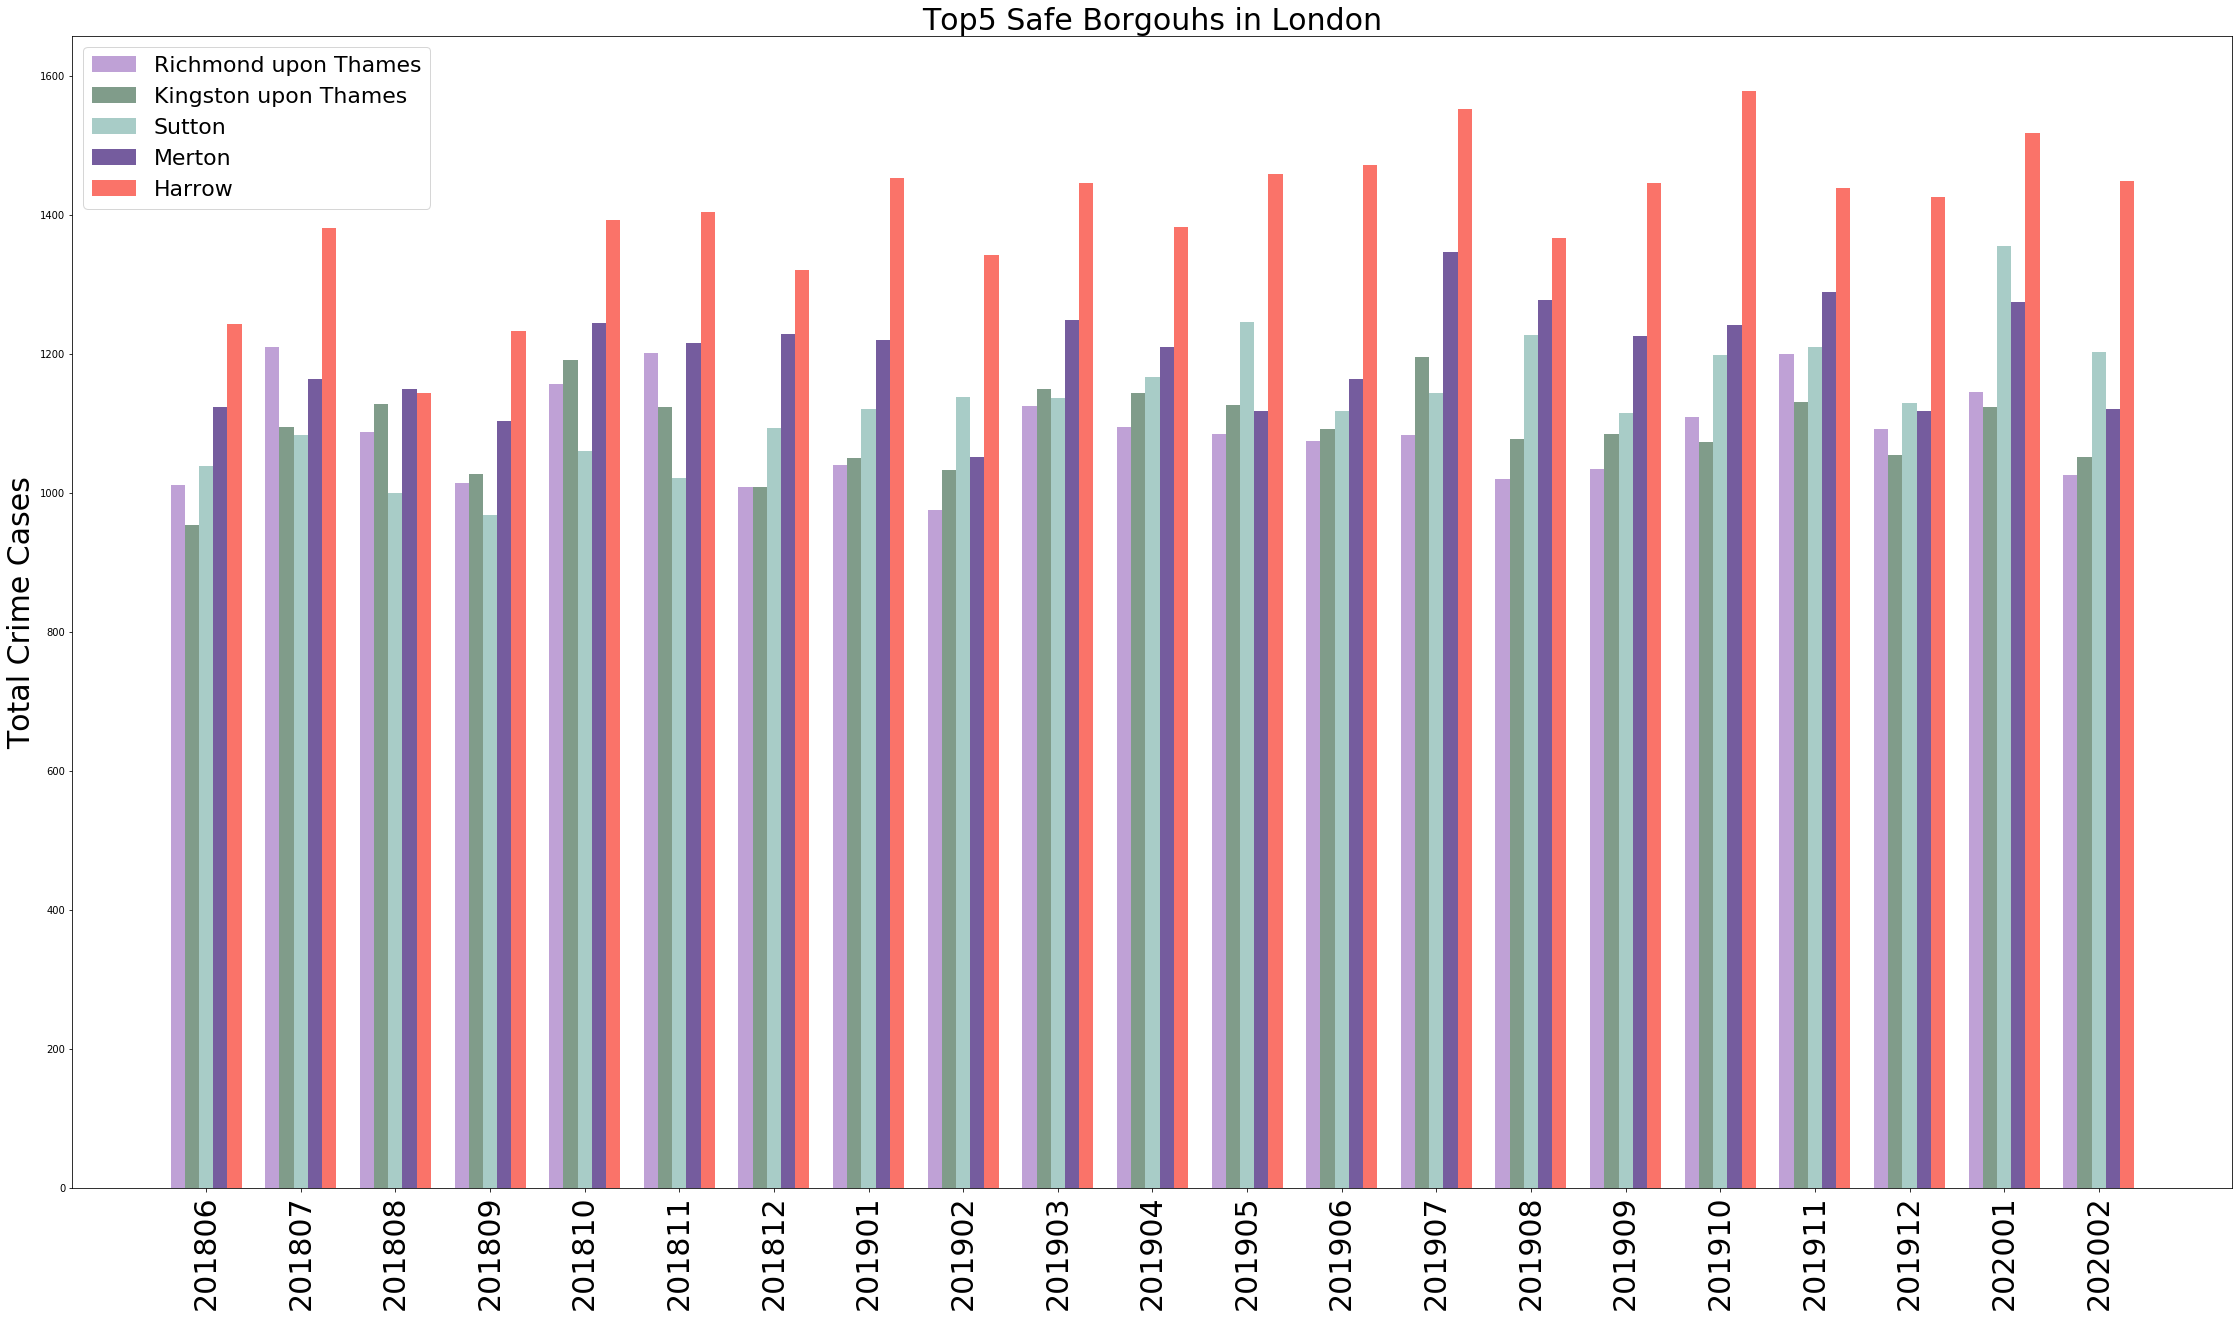

In [145]:
Xnum = df_borough_t5_t.shape[0]
X = np.arange(Xnum)
w = 0.15
xticks_g = labels_t5

plt.rcParams['figure.figsize']=(30.0,16.0)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

#Graph title
plt.title('Top5 Safe Borgouhs in London',fontsize=30)

#coloring the bars
ax.bar(X-2*w, df_borough_t5_t['Richmond upon Thames'], width = w, color=(cr_rt,cg_rt,cb_rt,1))
ax.bar(X-w,   df_borough_t5_t['Kingston upon Thames'], width = w, color=(cr_kt,cg_kt,cb_kt,1))
ax.bar(X,     df_borough_t5_t['Sutton'], width = w, color=(cr_s,cg_s,cb_s,1))
ax.bar(X+w,   df_borough_t5_t['Merton'], width = w, color=(cr_m,cg_m,cb_m,1))
ax.bar(X+2*w, df_borough_t5_t['Harrow'], width = w, color=(cr_h,cg_h,cb_h,1))


#for ticks
plt.xticks(X,xticks_g,rotation=90)
ax.set_xticklabels(xticks_g, rotation=90, fontsize=30.0)
ax.set_ylabel('Total Crime Cases',rotation=90, fontsize=30.0)

#for legend
Interests = ['Richmond upon Thames','Kingston upon Thames','Sutton','Merton','Harrow']
plt.legend(Interests, loc=2,fontsize=22)


#values above bars
#for i in ax.patches:
#    ax.text(i.get_x(), i.get_height()+1, str(round(i.get_height(), 2)), fontsize=6)
    
plt.show()

#### Seasonal tendency of the number of crimes are quite similar in all top 5 borouhgs. In order to focus on choosing the right place for my friend, I'll use the 